In [24]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm

import GetFailures as gf

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,2.5,5,7.5,10,12.5,15,17.5,100]
PFlucRange_labels = ['(0,2.5]','(2.5,5]','(5,7.5]','(7.5,10]','(10,12.5]','(12.5,15]','(15,17.5]','(17.5,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

# -------------------- CONST --------------------

In [26]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [27]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()
    
    return predoMaterials, failuresPMaterials


predoMaterials, failuresPMaterials = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

In [28]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)
    
def createBrokenAxisEffectNoRight(ax1, ax2):
    
    ax1.spines['bottom'].set_visible(False)
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    #ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    #ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return ax1, ax2

# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [29]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

def groupByFactor(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    #put into ranges and group by
    if col is not None:
        dfOK= putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol)
    else:
        dfOK= df[~pd.isna(df[colRanges])].copy()
        
    dfGroup= dfOK.groupby([MATERIAL,colRanges]).agg({'Shape_Leng':sum, 'Num of failures':sum}).copy()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup['Failures/Km/year']= dfGroup['Num of failures']/dfGroup['Shape_Leng']/6 
    #remove values with less than the 2% of that material
    dfGroup['Failures/Km/year']= dfGroup['Failures/Km/year'].where(dfGroup['%'] > MAX_PERCEN_TOSHOW, np.nan)
    
    return dfGroup

def getMaterialColRangeDis(df,col,rot=0,banc=(0.5, -0.13),percentage=True):
    
    #if does not have ticks then
    #sns.set_style("sticks")

    #transforming the data and getting the %
    if percentage:
        df['% of total length'] = df['Shape_Leng'] *100 / df['Shape_Leng'].sum()
        varDisplay, varName = '% of total length','% of total length'
    else:
        varDisplay, varName= 'Shape_Leng' ,"Length (km)"

    materialsColumns = df.reset_index().pivot(index=col, columns=MATERIAL, values=varDisplay)

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar( ax= ax, color= pal, rot=rot,alpha=0.7,stacked=True)

    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=banc)
    ax.set_ylabel(varName, multialignment='center');
    
    return fig1


# For pressure -------------------------------------------------------------------

In [30]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=[COMPKEY])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<1].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures



In [31]:
inService = predoMaterials[predoMaterials[STATUS] == INSERV_PROCESS].copy()
PiPress= getFailuresWithPressures(inService.copy())
PiPressAll= getFailuresWithPressures(predoMaterials.copy())

Total Length of pipes with pressure (GIS) 8569.67  in  186013 records
Total Length of pipes with VALID distance to pressure (GIS) 6569.65  in  131427 records
Total Length of pipes with pressure (GIS) 9172.63  in  198694 records
Total Length of pipes with VALID distance to pressure (GIS) 6864.60  in  137710 records


# # Complementary for the model ----------------------------------------------------

Weighted average of the models per leng 2012.4439714289558


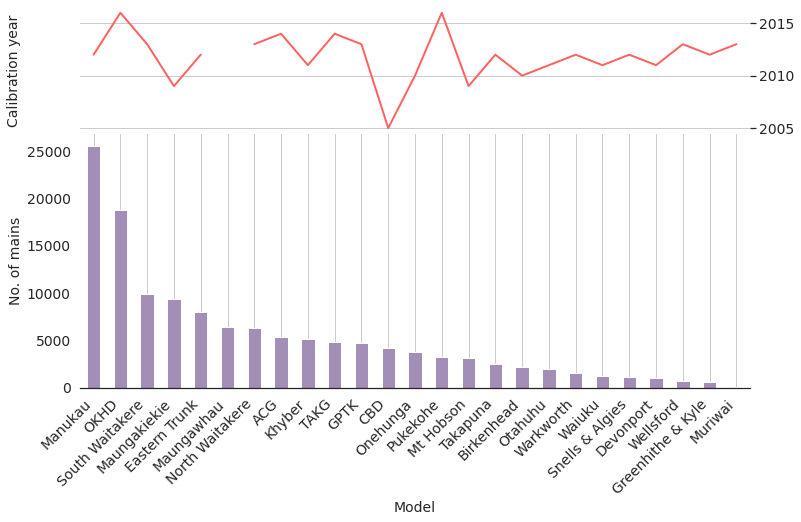

In [32]:
def getCalibrationYears(df):
    
    fModelExtent = 'Data/Pressure/WaterModelExtent_061020.csv'

    modelExtent = pd.read_csv(fModelExtent, delimiter = ',', dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64',
                                                                      'MOD_MINPRE':'float64','Press_fluc':'float64',
                                                                    'Distance': 'float64'})

    modelExtent['CAL_YEAR']= pd.to_datetime(modelExtent['CAL_DATE']).dt.year
    modelExtent['MODEL_NAME']=modelExtent.replace({'Albany, Cuthill & Glenfield':'ACG','Manukau Combined':'Manukau',
                                                  'Glenvar, Pinehill, Torbay and Kowhai':'GPTK'})
    
    dfExtCalYear= modelExtent.set_index('MODEL_NAME')[['CAL_YEAR']]
    
    dfNCalDate= df.join(dfExtCalYear,on='MODEL_NAME')
    assert df.shape[0] == dfNCalDate.shape[0]
    
    return dfNCalDate
    

def getNumberOfNodesPerModel(df):
    
    nodesPerModel= df.groupby(['MODEL_NAME']).agg({'Distance': 'count', 'Shape_Leng':'sum'}).sort_values(by='Distance',ascending=False)

    nodesPerModelNCal= getCalibrationYears(nodesPerModel.copy())
    
    Aux= nodesPerModelNCal.copy().dropna()
    print("Weighted average of the models per leng", np.average(Aux['CAL_YEAR'], weights=Aux['Shape_Leng']))
     
    fig, [ax1,ax]  = plt.subplots(2,figsize=(12,7),sharex=True,gridspec_kw={'height_ratios': [1, 2]})
    
    ax = nodesPerModel[['Distance']].plot.bar(ax= ax,color='#a28eb6')
    ax1= nodesPerModelNCal.plot(y='CAL_YEAR',ax= ax1,color='#ff6361',linewidth=2)
    
    for axA in [ax,ax1]:
        axA =removeTopRightFrame(axA)
        axA.spines['left'].set_visible(False)
        axA.legend().remove()
        
    ax.set_ylabel("No. of mains")
    ax.set_xlabel("Model")
    ax.grid(axis='x', which='both')
    
    ax1.yaxis.tick_right()
    ax1.grid(axis='y', which='both')
    ax1.spines['bottom'].set_visible(False)
    ax1.set_ylabel("Calibration year", labelpad=59)
    
    
    plt.xticks(ha='right',rotation=45)
    plt.subplots_adjust(hspace=0)
    
    fig.savefig('Maps_Graph/PressureAnalysis/'+ 'ModelsAnalysis' +'.png', dpi=200, bbox_inches='tight')
    
    #return nodesPerModelNCal

getNumberOfNodesPerModel(PiPress.copy())

In [10]:
def getDistributionPressures(df):
    
    fig, [ax1,ax2,ax3] = plt.subplots(3,figsize=(12, 4),sharex=True)
    
    for ax,v,c,l in zip([ax1,ax2,ax3],["MOD_MAXPRE","MOD_MINPRE","Press_fluc"],
                    ['#D95319','#EDB120','#77AC30'],["Max pressure (m)","Min pressure (m)","Fluctuation (m)"]):
    
        ax=sns.kdeplot(data=df, x=v, color=c,weights="Shape_Leng" , alpha=.5, ax=ax, cut=0,
                       fill=True, linewidth=2)
        
        ax.set(xlim=(-5, 150))
        ax.set(yticks=[])
        ax.spines['left'].set_visible(False)
        ax=removeTopRightFrame(ax)
        ax.set_xlabel("")
        ax.set_ylabel(l, rotation=0,ha='right',va="top")
        
        if ax != ax3:
            ax.spines['bottom'].set_visible(False)
        
        
    
    fig.savefig('Maps_Graph/PressureAnalysis/'+ 'PressureVariablesDistribution' +'.png', dpi=200, bbox_inches='tight')

   

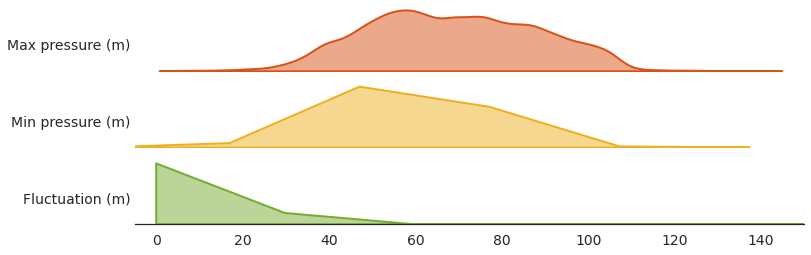

In [13]:
getDistributionPressures(PiPress)

In [14]:
PiPress[['MOD_MAXPRE','MOD_MINPRE','Press_fluc']].describe()

,MOD_MAXPRE,MOD_MINPRE,Press_fluc
count,131427.000000,131427.000000,131427.000000
mean,67.494733,56.825486,10.669247
std,19.478108,24.148787,18.338865
min,0.703210,-5852.653809,0.000000
25%,53.138142,43.808411,4.840605
50%,66.739075,56.273190,9.184100
75%,81.866261,69.247108,13.990200
max,144.802032,137.368073,5926.280000


In [103]:
#Validate values by ranges 
def getRegressionValuesPerPipe(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    dfOK= putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol)
      
    dfOK['Failures/Km/year']= dfOK['Num of failures']/dfOK['Shape_Leng']/6 
    
    dfOK.set_index("MATERIAL",inplace=True)
   
    for m in MATERIALS_PREDOMI:
        
        dfMat = dfOK.loc[m]
        
        y= dfMat[['Failures/Km/year']] #failure rate
        X= dfMat[[col]] #Maximum pressure
        w= dfMat[['Shape_Leng']] #length

        X = sm.add_constant(X)

        model = sm.WLS(y, X,weights=w).fit() 

        print(m,model.params[col], model.params['const'] )
        


# Extra for lines in conceptual model -----

In [113]:
#Validate values by ranges 
def getRegressionValuesPerPipeDouble(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    dfOK= putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2)
      
    dfOK['Failures/Km/year']= dfOK['Num of failures']/dfOK['Shape_Leng']/6 
    
    dfOK.set_index("MATERIAL",inplace=True)
   
    for m in MATERIALS_PREDOMI:
        
        dfMat = dfOK.loc[m]
        
        y= dfMat[['Failures/Km/year']] #failure rate
        X= dfMat[[col, col2]] #Maximum pressure, age
        w= dfMat[['Shape_Leng']] #length

        X = sm.add_constant(X)

        model = sm.WLS(y, X,weights=w).fit() 

        print(m," ", col, ": ",model.params[col], " ", col2, ": ",model.params[col2] , model.params['const'])

In [116]:
agePressdf= PiPressAll[['Shape_Leng',MATERIAL,'Num of failures','Age Today','MOD_MAXPRE']].copy() #or change to PiPressAll

Age_Range2 = np.arange(0, 110, 5).tolist()
AgeR_labels2 = [str(i) for i in np.arange(0, 105, 5).tolist()]

getRegressionValuesPerPipeDouble(agePressdf,"Current age (years)","Age Today",Age_Range2,AgeR_labels2,
                          "Maximum Pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels)

Pipe length with valid  Age Today and  MOD_MAXPRE 6682.43  from original  6864.60
AC   Age Today :  0.005215942964923632   MOD_MAXPRE :  0.003107370200661452 -0.1467183055736508
PVC   Age Today :  0.00833839466617297   MOD_MAXPRE :  0.004759254320404566 -0.3437581029240286
Iron   Age Today :  0.0007220651950481159   MOD_MAXPRE :  0.002569770720158601 -0.013332704401138429
PE   Age Today :  0.007660310130191018   MOD_MAXPRE :  0.0047601550512461266 -0.3121283899993874


In [125]:
print("Regression by each pipe, age vs failure rate for only 10 to 20 years")

agedf= PiPressAll[['Shape_Leng',MATERIAL,'Num of failures','Age Today','MOD_MAXPRE']].copy() #or change to PiPressAll
agedf = agedf[agedf['MOD_MAXPRE']>=30 ]
agedf = agedf[agedf['MOD_MAXPRE']<=40 ]
agedf = agedf[agedf['Age Today']>15 ]

Age_Range2 = np.arange(0, 110, 5).tolist()
AgeR_labels2 = [str(i) for i in np.arange(0, 105, 5).tolist()]

getRegressionValuesPerPipe(agedf,"Current age (years)","Age Today",Age_Range2,AgeR_labels2,None,None,None)

Regression by each pipe, age vs failure rate for only 10 to 20 years
(Main in service) Pipe length with valid  Age Today  329.89  from original  334.35
AC -0.0015488216832537445 0.3005700983862494
PVC 0.005066124691091115 0.013663064076424997
Iron 0.002567131448878318 0.02895021685185132
PE 0.0115410001692868 -0.17904263448458588


In [127]:
print("Regression by each pipe, age vs failure rate for only 10 to 20 years")

agedf= PiPressAll[['Shape_Leng',MATERIAL,'Num of failures','Age Today','MOD_MAXPRE']].copy() #or change to PiPressAll
agedf = agedf[agedf['MOD_MAXPRE']>=55 ]
agedf = agedf[agedf['MOD_MAXPRE']<=65 ]
agedf = agedf[agedf['Age Today']>15 ]

Age_Range2 = np.arange(0, 110, 5).tolist()
AgeR_labels2 = [str(i) for i in np.arange(0, 105, 5).tolist()]

getRegressionValuesPerPipe(agedf,"Current age (years)","Age Today",Age_Range2,AgeR_labels2,None,None,None)

Regression by each pipe, age vs failure rate for only 10 to 20 years
(Main in service) Pipe length with valid  Age Today  1123.82  from original  1145.34
AC 0.0059602052646453 0.014773147062567818
PVC 0.008748488124123585 -0.09762620079527849
Iron -0.0011321802791035825 0.27982189061753915
PE 0.012735607174353701 -0.16149495752155146


# From Base Analysis ------------------------------------------------------------------

# End of Basis analysis ---------------------------------------------------------

(Main in service) Pipe length with valid  MOD_MAXPRE  6817.93  from original  6864.60
(Main in service) Pipe length with valid  Press_fluc  6767.40  from original  6768.77


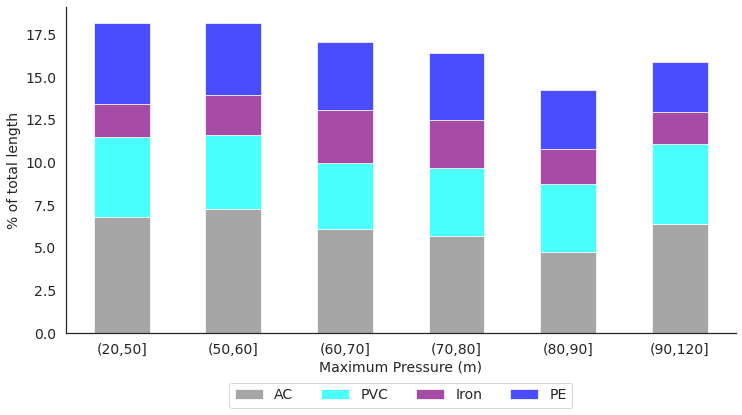

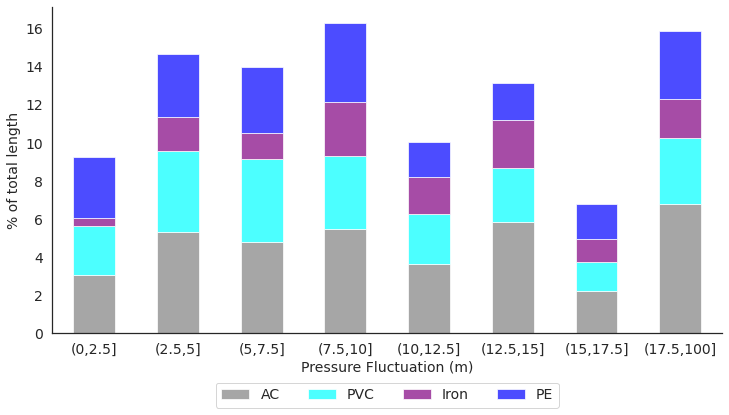

In [34]:
def getMaterialPressureRangeDis(df):
    
    dfGroupPressure= groupByFactor(df.copy(),"Maximum Pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,None,None,None)
    
    fig1=getMaterialColRangeDis(dfGroupPressure,"Maximum Pressure (m)")
    fig1.savefig('Maps_Graph/PressureAnalysis/'+'MaterialPressRangeDis' +'.png', dpi=200, bbox_inches='tight')


def getMaterialPressureFlucRangeDis(df):
    
    dfOK= df[(df["MOD_MAXPRE"]>=20) & (df["MOD_MINPRE"]>=20) & (df["MOD_MAXPRE"]<120) & (df["MOD_MINPRE"]<120)]
    
    dfGroupPressure= groupByFactor(dfOK.copy(),"Pressure Fluctuation (m)","Press_fluc",PressFluc_bins,PFlucRange_labels,None,None,None)
    
    fig1=getMaterialColRangeDis(dfGroupPressure,"Pressure Fluctuation (m)")
    fig1.savefig('Maps_Graph/PressureAnalysis/'+'MaterialFlucRangeDis' +'.png', dpi=200, bbox_inches='tight')


getMaterialPressureRangeDis(PiPressAll.copy())

getMaterialPressureFlucRangeDis(PiPressAll.copy())

# From Base anaylis -------------------------------------------------------------------

In [35]:
def getMaterialColBurstRate(dfGroup,col):

    materialsColumns = dfGroup.reset_index().pivot(index=col, columns=MATERIAL, values='Failures/Km/year')

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot(ax= ax, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=12)
    ax = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=5)
    
    #remove second legen
    lines, labels = ax.get_legend_handles_labels()
    
    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(lines[4:], labels[4:],ncol=4, facecolor='white',fontsize=14)
    ax.set_ylim(bottom=0)
    
    ax.set_ylabel("Failure rate (Failures/Km/year)", multialignment='center');

    return fig1 , ax


# Finish Base anaylis ------------------------------------------------------------------

(Main in service) Pipe length with valid  MOD_MAXPRE  6529.43  from original  6569.65
(Main in service) Pipe length with valid  Press_fluc  6567.86  from original  6569.65


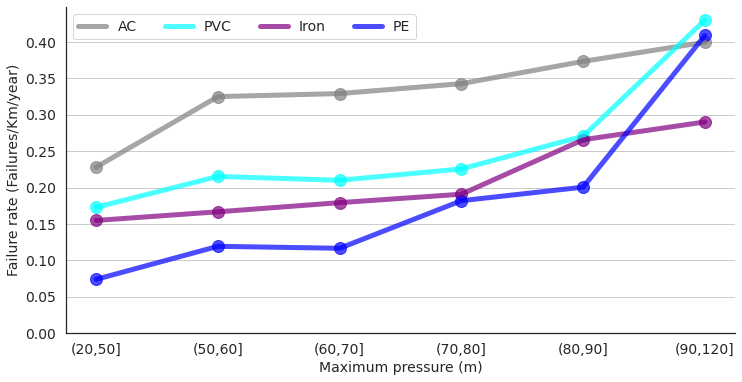

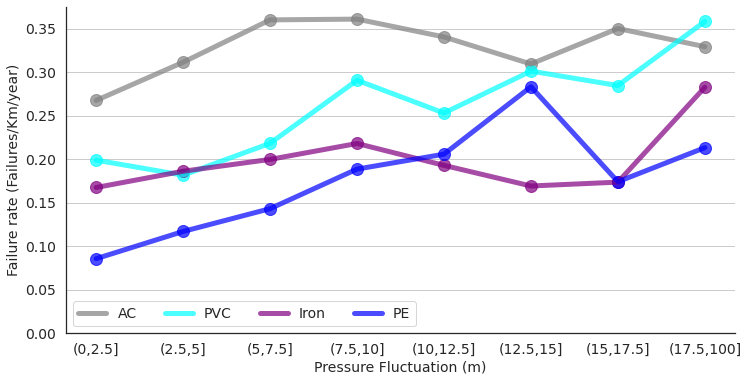

In [39]:
def getBurstRateVsPress(df):

    dfGroupPress= groupByFactor(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,None,None,None)
    
    fig1, ax =getMaterialColBurstRate(dfGroupPress,'Maximum pressure (m)')
    loc = plticker.MultipleLocator(base=2.5)
    ax.xaxis.set_minor_locator(loc)
    ax.grid(axis='y', which='both')#,color='#ffffff')
    
   # for the ppt --------------
   # ax.tick_params(axis='both',colors= '#ffffff')
   # ax.spines['bottom'].set_color('#ffffff')
   # ax.spines['bottom'].set_linewidth(3)
   # ax.spines['left'].set_color('#ffffff')
   # ax.spines['left'].set_linewidth(3)
  
    fig1.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressure' +'.png', dpi=200, bbox_inches='tight',
                transparent=True)

    
def getBurstRateVsPressFluct(df):
    
    dfOK= df[(df["MOD_MAXPRE"]>=20) & (df["MOD_MINPRE"]>=20) & (df["MOD_MAXPRE"]<120) & (df["MOD_MINPRE"]<120)]

    dfGroupPress= groupByFactor(df,"Pressure Fluctuation (m)","Press_fluc",PressFluc_bins,PFlucRange_labels,None,None,None)
    
    fig1, ax =getMaterialColBurstRate(dfGroupPress,'Pressure Fluctuation (m)')
    ax.grid(axis='y', which='both')

    fig1.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressureFluc' +'.png', dpi=200, bbox_inches='tight',
                 transparent=True)


getBurstRateVsPress(PiPress.copy())
getBurstRateVsPressFluct(PiPress.copy())

In [37]:
def putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    df[colRanges2]= pd.cut(df[col2], bins=bins2, labels=labels2)
    
    #remove invalid values (nulls)----------------------------------
    dfOK= df.dropna(subset=[colRanges, colRanges2]).copy()
     
    print("Pipe length with valid ",col+" and ", col2,"%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

def groupByTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    #put into ranges and group by    
    dfOK= putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2)
        
    dfGroup= dfOK.groupby([MATERIAL,colRanges,colRanges2]).agg({'Shape_Leng':sum, 'Num of failures':sum, col2: 'mean'}).copy()

    dfGroup= dfGroup.dropna(subset=['Shape_Leng']).copy()
    assert dfOK['Num of failures'].sum() == dfGroup['Num of failures'].sum()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup['Failures/Km/year']= dfGroup['Num of failures']/dfGroup['Shape_Leng']/6 
    
    return dfGroup

In [133]:
def getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,var):
    
    regres=[]
    
    for d in diamColumns.columns.tolist():
        
        y= diamColumns[d].dropna()
        X= diamColumnsMeanPress[d][diamColumnsMeanPress[d].index.isin(y.index)]
        w= diamColumnsLeng[d][diamColumnsLeng[d].index.isin(y.index)]
            
        if (not any(np.isnan(X)) and (len(y)>2)):
          
            X = sm.add_constant(X)

            model = sm.WLS(y, X,weights=w).fit() 

            #material, diameter, slope, intercept, std dev, p-value of the slope, rsquared
            regres.append([d,model.params[d], model.params['const'], 
                           model.bse[d], model.pvalues[d], model.rsquared])
    
    df=pd.DataFrame(regres, columns =[var, 'Slope', 'Intercept', 
                                      'Std dev', 'Slope P-value', 'Rsquared'])
    
    df.to_csv('Output/Regressions/'+"PressureVsFailR"+var+m+'.csv') 
    return df
        
    
def getBurstRatePressMatPerDiameterRanges(m,failures,lengths,name,pal):
    
     #start of the graph
    fig1, [ax2,ax]  = plt.subplots(2,figsize=(12,8),sharex=True, gridspec_kw={'height_ratios': [1, 3]})

    ax = failures.plot(ax= ax, rot=0, alpha=0.5, marker='o',linewidth=5, ms=12,color=pal)
    ax = failures.interpolate(method='linear',limit_area='inside').plot(ax= ax, rot=0, alpha=0.7, linewidth=5, color=pal)
        
    #styling
    ax = removeTopRightFrame(ax)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[5:], labels[5:],ncol=5,fontsize=14,facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Failure rate (Failures/Km/year)", multialignment='center');
    ax.grid(axis='y', which='both')
        
    #Bar plot on top
    ax2 = lengths.plot.bar( ax= ax2, color= pal, alpha=0.7)

    #styling
    ax2 = removeTopRightFrame(ax2)
    ax2.legend().remove()
    ax2.yaxis.set_major_locator(plticker.MultipleLocator(50))
    ax2.yaxis.set_minor_locator(plticker.MultipleLocator(100))
    ax2.grid(axis='y', which='both')
    ax2.set_ylabel("Pipe length (Km)", multialignment='center');
        
        
    ax2.set_title(name,fontsize=14 )
    plt.subplots_adjust(hspace=0.1)
        
    fig1.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressure'+m +'.png', dpi=200, bbox_inches='tight')

def getBurstRatePressMatDiamScatter(df,xlabel,material,m,pal,col,groupbyRang,label):
    
    #regressions
    g = sns.lmplot(data=df,x=col, y="Failures/Km/year", hue=groupbyRang,
                       height=6, aspect=1.8, palette=pal,legend=False,robust=True, truncate=True,
                       scatter_kws={'alpha': 0.5,'s':80}, line_kws={'lw': 5,'alpha': 0.7})
        
    sns.despine(left=True)
    plt.legend(ncol=6, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))
    
    g.axes[0][0].set_xlabel(xlabel)
    g.axes[0][0].set_ylabel("Failure rate (Failures/Km/year)")
    g.axes[0][0].grid(axis='y', which='both')
    g.axes[0][0].set_title(material,fontsize=14 )
    g.set(ylim=(0, None))
        
    g.fig.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressReg'+label+m+'.png', dpi=200, bbox_inches='tight')
 
        
def getBurstRatePressMatPerRanges(m,failures,lengths,name,pal,numCat,var,col):
    
    #shorten x axis
    failures.dropna(axis='rows',how='all',inplace=True)
    indexToDrop = [r for r in lengths.index.tolist() if r not in failures.index.tolist()]
    lengths.drop(index=indexToDrop, inplace=True)
    
    #start of the graph
    fig1, [ax2,ax]  = plt.subplots(2,figsize=(12,8),sharex=True, gridspec_kw={'height_ratios': [1, 3]})

    ax = failures.plot(ax= ax, rot=0, alpha=0.5, marker='o',linewidth=5, ms=12,color=pal)
    ax = failures.interpolate(method='linear',limit_area='inside').plot(ax= ax, rot=0, alpha=0.7, linewidth=5, color=pal)
        
    #styling
    ax = removeTopRightFrame(ax)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[numCat:], labels[numCat:],ncol=col,fontsize=14,facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Failure rate (Failures/Km/year)", multialignment='center');
    ax.grid(axis='y', which='both')
        
    #Bar plot on top
    ax2 = lengths.plot.bar( ax= ax2, color= pal, alpha=0.7)
 
    #styling
    ax2 = removeTopRightFrame(ax2)
    ax2.legend().remove()
    ax2.yaxis.set_major_locator(plticker.MultipleLocator(50))
    ax2.yaxis.set_minor_locator(plticker.MultipleLocator(100))
    ax2.grid(axis='y', which='both')
    ax2.set_ylabel("Pipe length (Km)", multialignment='center');
    ax2.set_title(name,fontsize=14 )
    plt.subplots_adjust(hspace=0.1)
        
    fig1.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressure'+var+m +'.png', dpi=200, bbox_inches='tight')
       
def getBurstRateColMatPer(df,colRanges,col,colBins,colLabels,colRanges2,col2,colBins2,colLabels2,label):
    
    # division constants
    numCat=len(colLabels2)
    names = getMaterialConst()['NAME']
    
    #Style constants
    pale= cmlib.hot(np.linspace(0, 1, numCat+1))
    
    
    dfGroupDiam= groupByTwoFactors(df,colRanges2,col2,colBins2,colLabels2,
                                      colRanges,col,colBins,colLabels)
    
    #remove values with less than the 1% of that material
    dfGroupDiam['Failures/Km/year']= dfGroupDiam['Failures/Km/year'].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam['Shape_Leng']= dfGroupDiam['Shape_Leng'].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam= dfGroupDiam.reset_index().copy()
    
    for m in MATERIALS_PREDOMI: 
        
        dfG= dfGroupDiam[dfGroupDiam["MATERIAL"]==m].copy()
        
        diamColumns=dfG.pivot(index=colRanges, columns=colRanges2, values='Failures/Km/year').copy()
        diamColumnsLeng=dfG.pivot(index=colRanges, columns=colRanges2, values='Shape_Leng').copy()
        diamColumnsMeanPress=dfG.pivot(index=colRanges, columns=colRanges2, values=col).copy()
         
        #regressions
        getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,label)
        
        #graph in ranges
        getBurstRatePressMatPerRanges(m,diamColumns,diamColumnsLeng,names[m],pale,numCat,label,numCat)
        
        #graph regressions
        #getBurstRatePressMatDiamScatter(dfG,colRanges,names[m],m,pale,col,colRanges2,label)
      
    

def getMaxPressFailureGraphs(df):
    
    Age_Range2 = np.arange(0, 115, 10).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 105, 10).tolist()]
    Diam_bins2 = [25, 75, 115, 190, 225,800]
    DRange_labels2 = ['50','100', '125-175','200','>200']

    #getBurstRateColMatPerDiameter(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels)
    
    #getBurstRateColMatPer(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,
                         #"Current age (years)","Age Today",Age_Range2,AgeR_labels2,"Max&Age")
    
    getBurstRateColMatPer(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,
                         "Diameter (mm)","NOM_DIA_MM",Diam_bins2,DRange_labels2,"Max&Diam")


def getPressFlucFailureGraphs(df):
    
    dfOK= df[(df["MOD_MAXPRE"]>=20) & (df["MOD_MINPRE"]>=20) & (df["MOD_MAXPRE"]<120) & (df["MOD_MINPRE"]<120)].copy()

    
    Age_Range2 = np.arange(0, 115, 10).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 105, 10).tolist()]
    
    PressMax_bins2 = [20,80,120]
    PMaxRange_labels2 = ['(20,80]','(80,120]']
    
    #numCat=11
     
    #getBurstRateColMatPerDiameter(dfOK,"Pressure Fluctuation (m)","Press_fluc",PressFluc_bins,PFlucRange_labels)
    
    #getBurstRateColMatPer(dfOK,"Pressure Fluctuation (m)","Press_fluc",PressFluc_bins,PFlucRange_labels,
                        # "Maximum pressure (m)","MOD_MAXPRE",PressMax_bins2,PMaxRange_labels2,"Fluc&Max") 
    
    getBurstRateColMatPer(dfOK,"Pressure Fluctuation (m)","Press_fluc",PressFluc_bins,PFlucRange_labels,
                         "Current age (years)","Age Today",Age_Range2,AgeR_labels2,"Fluc&Age") 


Pipe length with valid  NOM_DIA_MM and  MOD_MAXPRE 6777.69  from original  6864.60


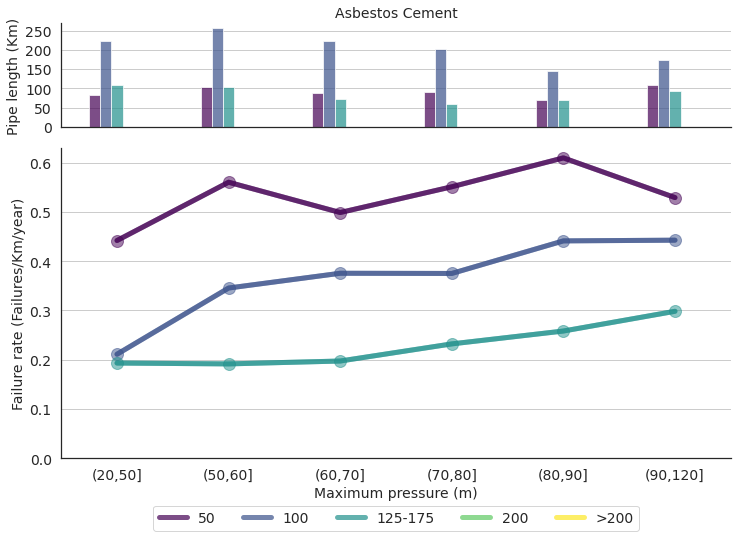

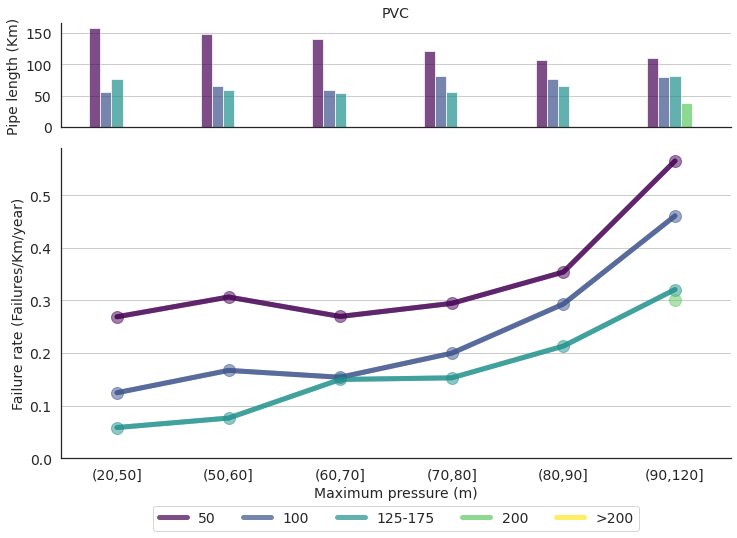

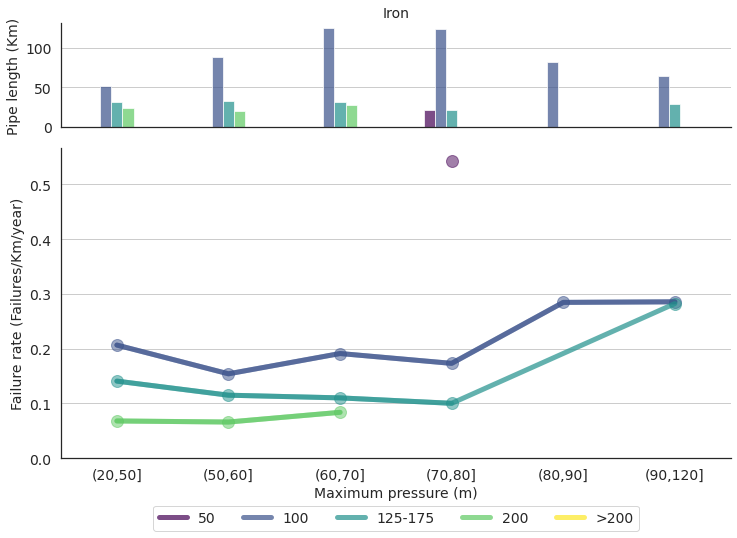

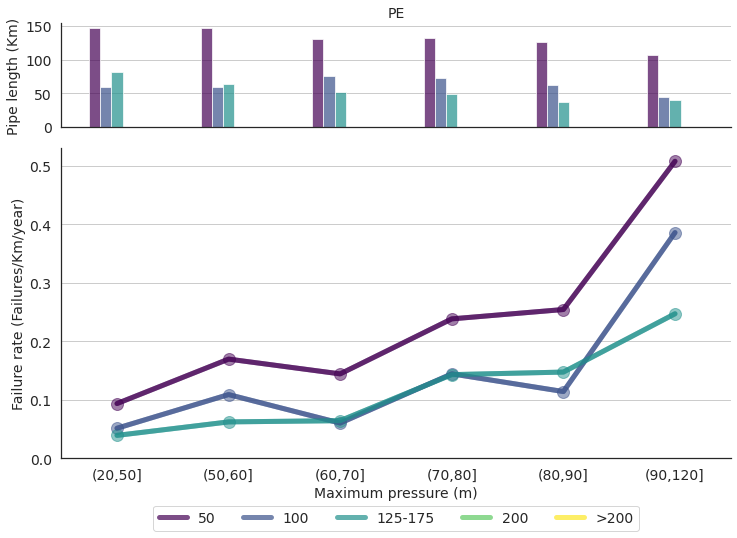

In [52]:
getBurstRateVsPressByMatDiam(PiPressAll.copy())

In [18]:
getMaxPressFailureGraphs(PiPressAll.copy())

Pipe length with valid  NOM_DIA_MM and  MOD_MAXPRE 6777.69  from original  6864.60


In [107]:
getPressFlucFailureGraphs(PiPressAll.copy())

Pipe length with valid  Age Today and  Press_fluc 6756.20  from original  6768.77


Pipe length with valid  NOM_DIA_MM and  MOD_MAXPRE 6777.69  from original  6864.60
Pipe length with valid  Age Today and  MOD_MAXPRE 6806.73  from original  6864.60


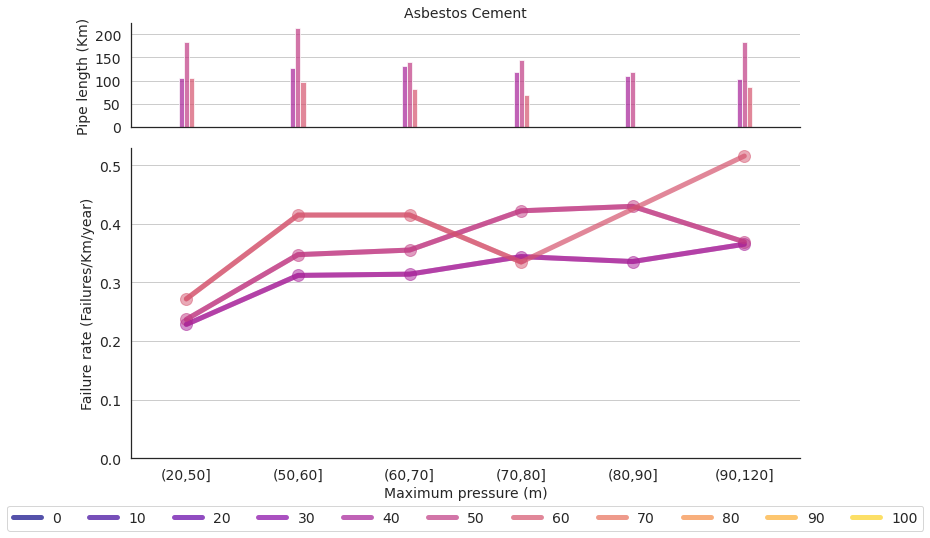

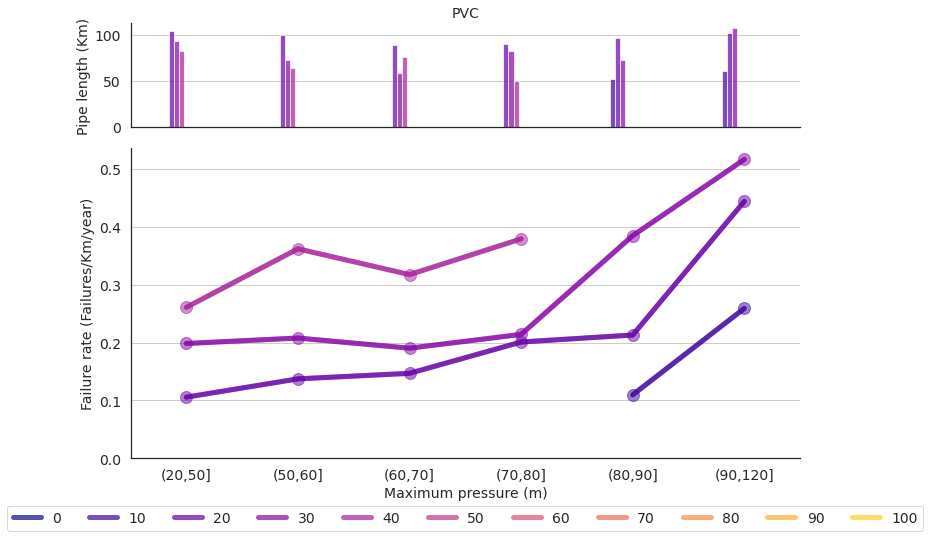

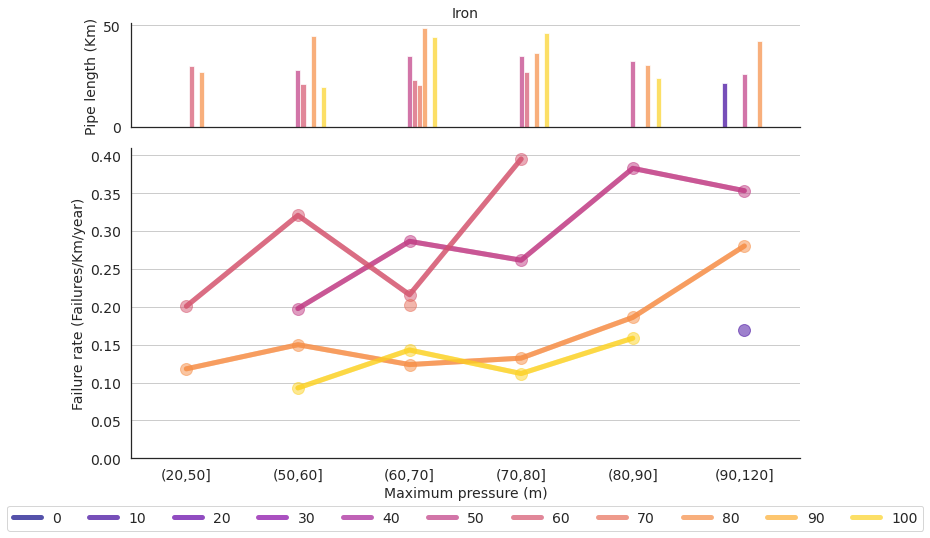

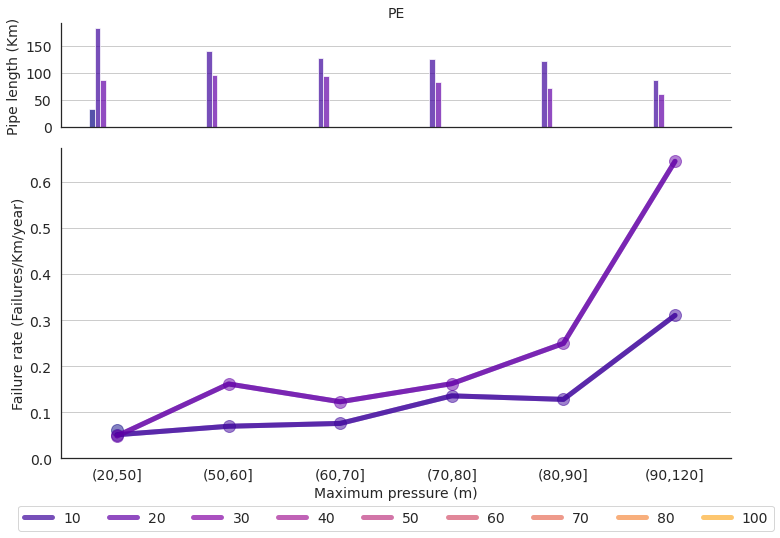

In [43]:
getMaxPressFailureGraphs(PiPressAll.copy())

In [50]:
def getAgeMaxPressFailureGraphs(df):
    
    Age_Range2 = np.arange(0, 110, 5).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 105, 5).tolist()]
    
    #getBurstRateColMatPerDiameter(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels)
    
    #getBurstRateColMatPer(df,"Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,
                         #"Current age (years)","Age Today",Age_Range2,AgeR_labels2,"Max&Age")
    
    getBurstRateColMatPer(df,"Current age (years)","Age Today",Age_Range2,AgeR_labels2,
                         "Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,"Age&Max")

Pipe length with valid  MOD_MAXPRE and  Age Today 6682.43  from original  6864.60


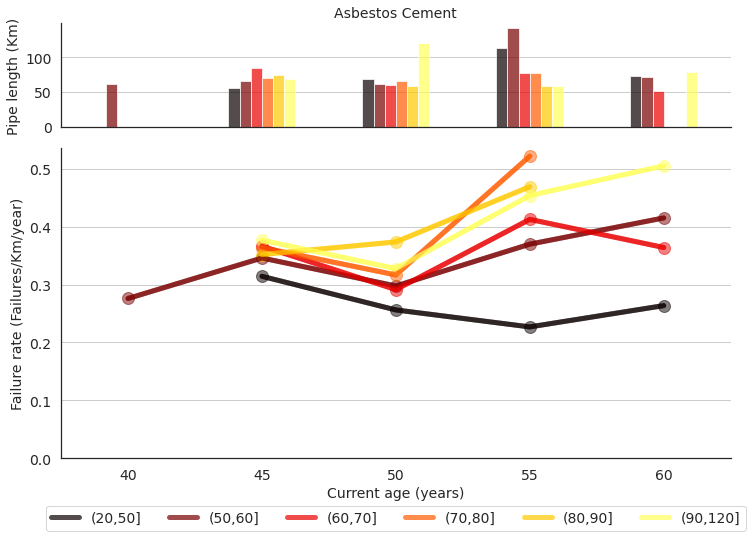

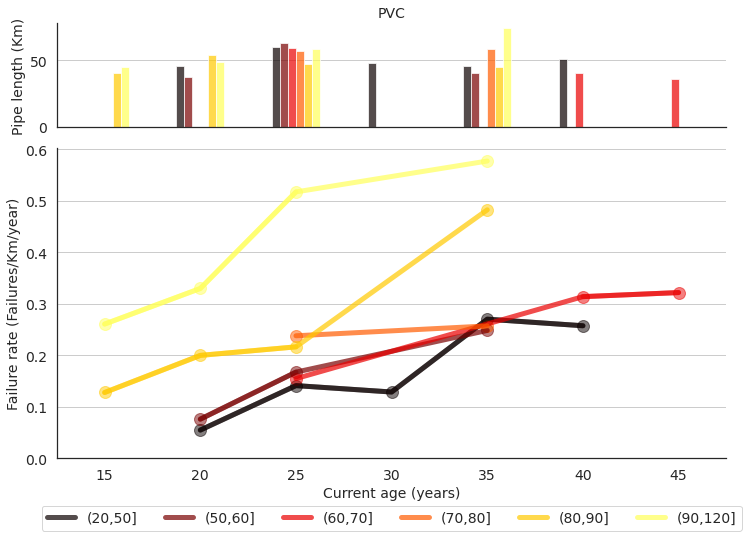

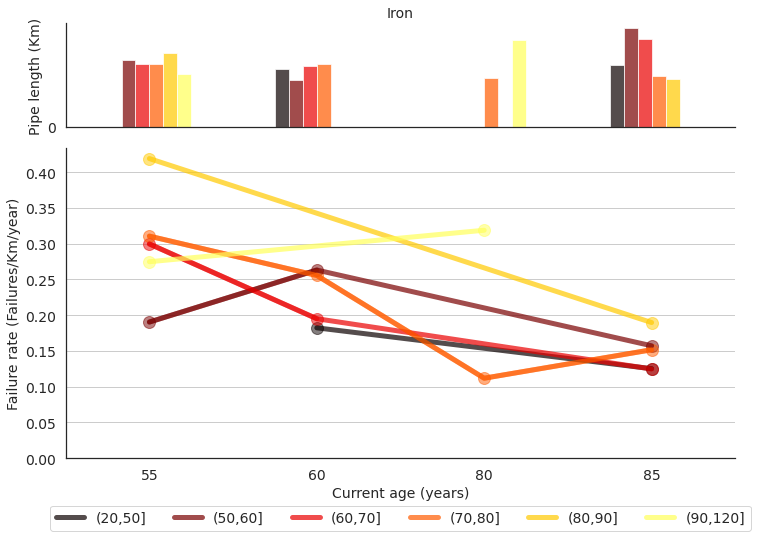

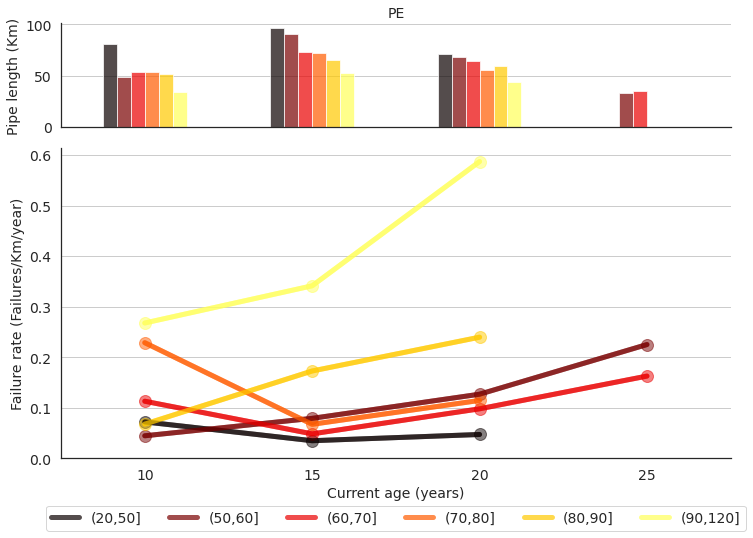

In [131]:
getAgeMaxPressFailureGraphs(PiPressAll.copy())

Pipe length with valid  MOD_MAXPRE and  Age Today 6345.41  from original  6395.55


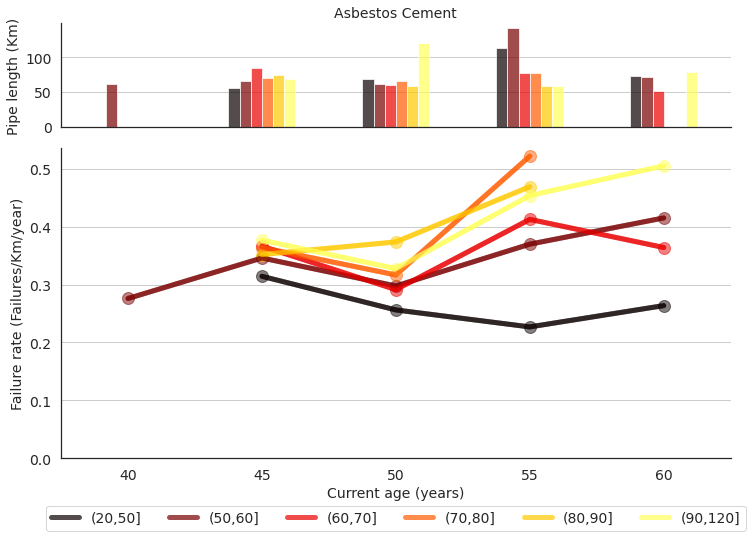

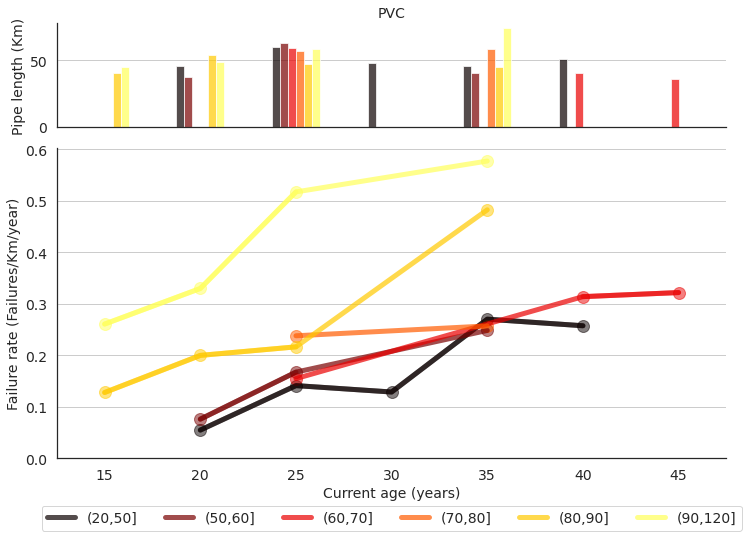

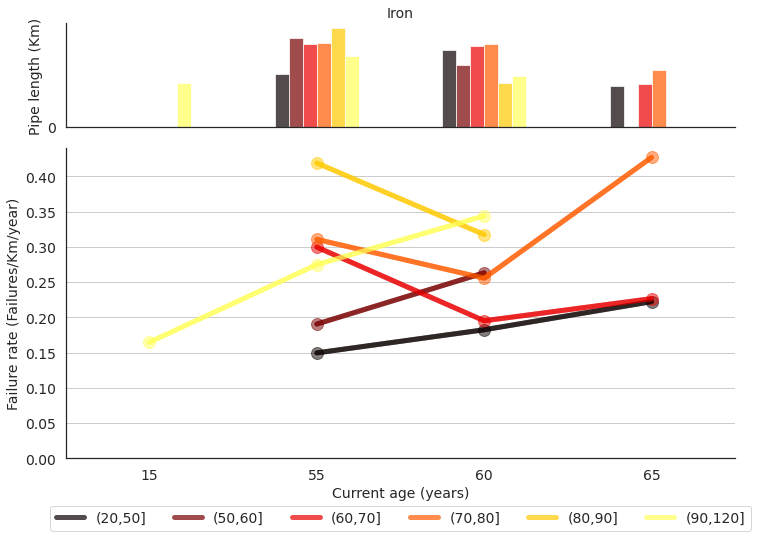

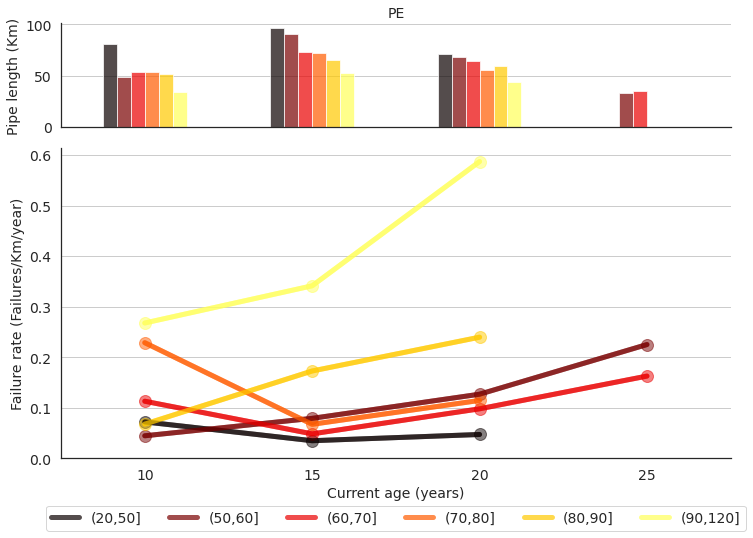

In [231]:
dfAux= PiPressAll[~((PiPressAll[MATERIAL]==IRON) & (PiPressAll['Age Today']>70))].copy()

getAgeMaxPressFailureGraphs(dfAux.copy())

# # OLD---------------------------------------------------------------------------------

In [ ]:
def pressureAnalysisHistogram(wPipesGISNfailures):

	materialsConst =getMaterialConst()

	wPipesGISNfailPresOK, groupMatDiam = getFailuresWithPressures(wPipesGISNfailures)
	    
	print('Total Length of the summary of pipes:', "%.2f" % groupMatDiam['Shape_Leng'].sum(), ' with ', groupMatDiam['Num of failures'].sum() , ' failures')


	wm = lambda x: np.average(x, weights=wPipesGISNfailPresOK.loc[x.index, "Shape_Leng"])
	groupMatDiamRPreR = wPipesGISNfailPresOK.groupby([MATERIAL, 'Diam_Range', 'PreMax_Range' ]).agg({'Shape_Leng': 'sum' ,'Num of failures': 'sum',
	                                              'MOD_MAXPRE': wm}).copy()


	groupMatDiamRPreR['Failures/100km/year'] =  groupMatDiamRPreR['Num of failures'] / groupMatDiamRPreR['Shape_Leng'] / 6 *100

	print('Total Length of the graph table:', "%.2f" % groupMatDiamRPreR['Shape_Leng'].sum(), 'km with ', groupMatDiamRPreR['Num of failures'].sum() , ' failures')
	lenDiam = groupMatDiamRPreR['Shape_Leng']
	groupMatDiamRPreR.drop(columns=['Shape_Leng', 'Num of failures'], inplace=True)

	#groupMatDiamRPreR.drop(index= OTHER, level=0,inplace=True)
	materials = groupMatDiamRPreR.reset_index(level=['Diam_Range','PreMax_Range']).index.unique().tolist()
	diameterConst = getDiameterConst()
	cmap = cmlib.get_cmap('viridis') 
	labels = PMaxRange_labels
	maxFail = groupMatDiamRPreR.max()
	histoT = wPipesGISNfailPresOK[['Shape_Leng',MATERIAL,'MOD_MAXPRE']].set_index(MATERIAL).copy()

	eqs = []

	for material in materials: 
	    valMaterial = groupMatDiamRPreR.loc[material]
	    valMaterial = valMaterial.unstack(level=0)
	    valMaterial.dropna(axis='columns',how='all', inplace=True)

	    totalKm = groupMatDiam.loc[[material]]['Shape_Leng'].sum()
	    totalF = groupMatDiam.loc[[material]]['Num of failures'].sum()
	    
	    if valMaterial.shape[0] > 0:

	        valMaterial = iterateTable(valMaterial, groupMatDiam, material, totalKm , totalF)

	        fig = plt.figure(figsize=(10, 8))
	        gs = fig.add_gridspec(2, 1, height_ratios=(2, 7),
	                              left=0.1, right=0.9, bottom=0.1, top=0.9,
	                              wspace=0.05, hspace=0.05)

	        ax = fig.add_subplot(gs[1, 0])
	        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
	        
	        
	        for dr in valMaterial['MOD_MAXPRE'].columns.tolist():
	            diam = diameterConst.loc[dr]
	            lenD = groupMatDiam.loc[material,dr]['Shape_Leng'] 
	            x=valMaterial['MOD_MAXPRE',dr].to_numpy().reshape((-1, 1))
	            y=valMaterial['Failures/100km/year',dr].to_numpy()
            
	            ax.plot(x, y,
	                    c=cmap(diam['Color']), marker= diam['Marker'],linewidth=5, ms=12, alpha= (lenD/totalKm+0.2),
	                    label= groupMatDiam.loc[material,dr]['Legend'])

	            #Linear regression
	            model = LinearRegression().fit(x, y)
	            eqs.append([material,dr,model.score(x, y), model.coef_[0], model.intercept_,lenD,totalKm])
	            yPredicted = model.predict(x)
	                
	            ax.plot(x, yPredicted, c='blueviolet',linestyle='--',linewidth=1, alpha= 0.5)
	            
	        
	        loc = plticker.MultipleLocator(base=20)
	        ax.yaxis.set_minor_locator(loc)
	        ax.yaxis.set_major_locator(loc)
	        ax.yaxis.grid()
	        ax.set_xlabel("Max pressure (m)")
	        ax.set_ylabel("Failure rate (failures/100km/year)")
	        ax_histx.set_ylabel("Frecuency",fontsize=16)

	        
	        ax_histx.set_title(materialsConst.loc[material]['NAME'] + '(' + "%.0f" % totalF + ' failures/'+ "%.0f" % totalKm + ' Km)', fontsize=16)
	        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=14)

	        
	        modDp_bins = PressMax_bins.copy()
	        modDp_bins[6]= valMaterial['MOD_MAXPRE'].max().max()
	        histoT.loc[material,'MOD_MAXPRE'].plot(kind='hist',ax=ax_histx, bins=modDp_bins,  weights=histoT.loc[material,"Shape_Leng"], ec='black',alpha=0.5) # add boxplot to 2nd subplot
	        ax_histx = removeTopRightFrame(ax_histx)
	        ax = removeTopRightFrame(ax)
	        ax_histx.spines['left'].set_visible(False)
	        ax_histx.yaxis.grid()


	        fig.savefig('Maps_Graph/PressureAnalysis/'+ material +'VsMaxPressureWITHLINES' +'.png', dpi=200, bbox_inches='tight')


	linearEqs = pd.DataFrame(eqs, columns=[MATERIAL,'DiamR','r2','slope','b','lenDiameter','totalKmMaterial'])
	linearEqs.to_csv('Output/PressureAnalysisLinearEqu.csv')




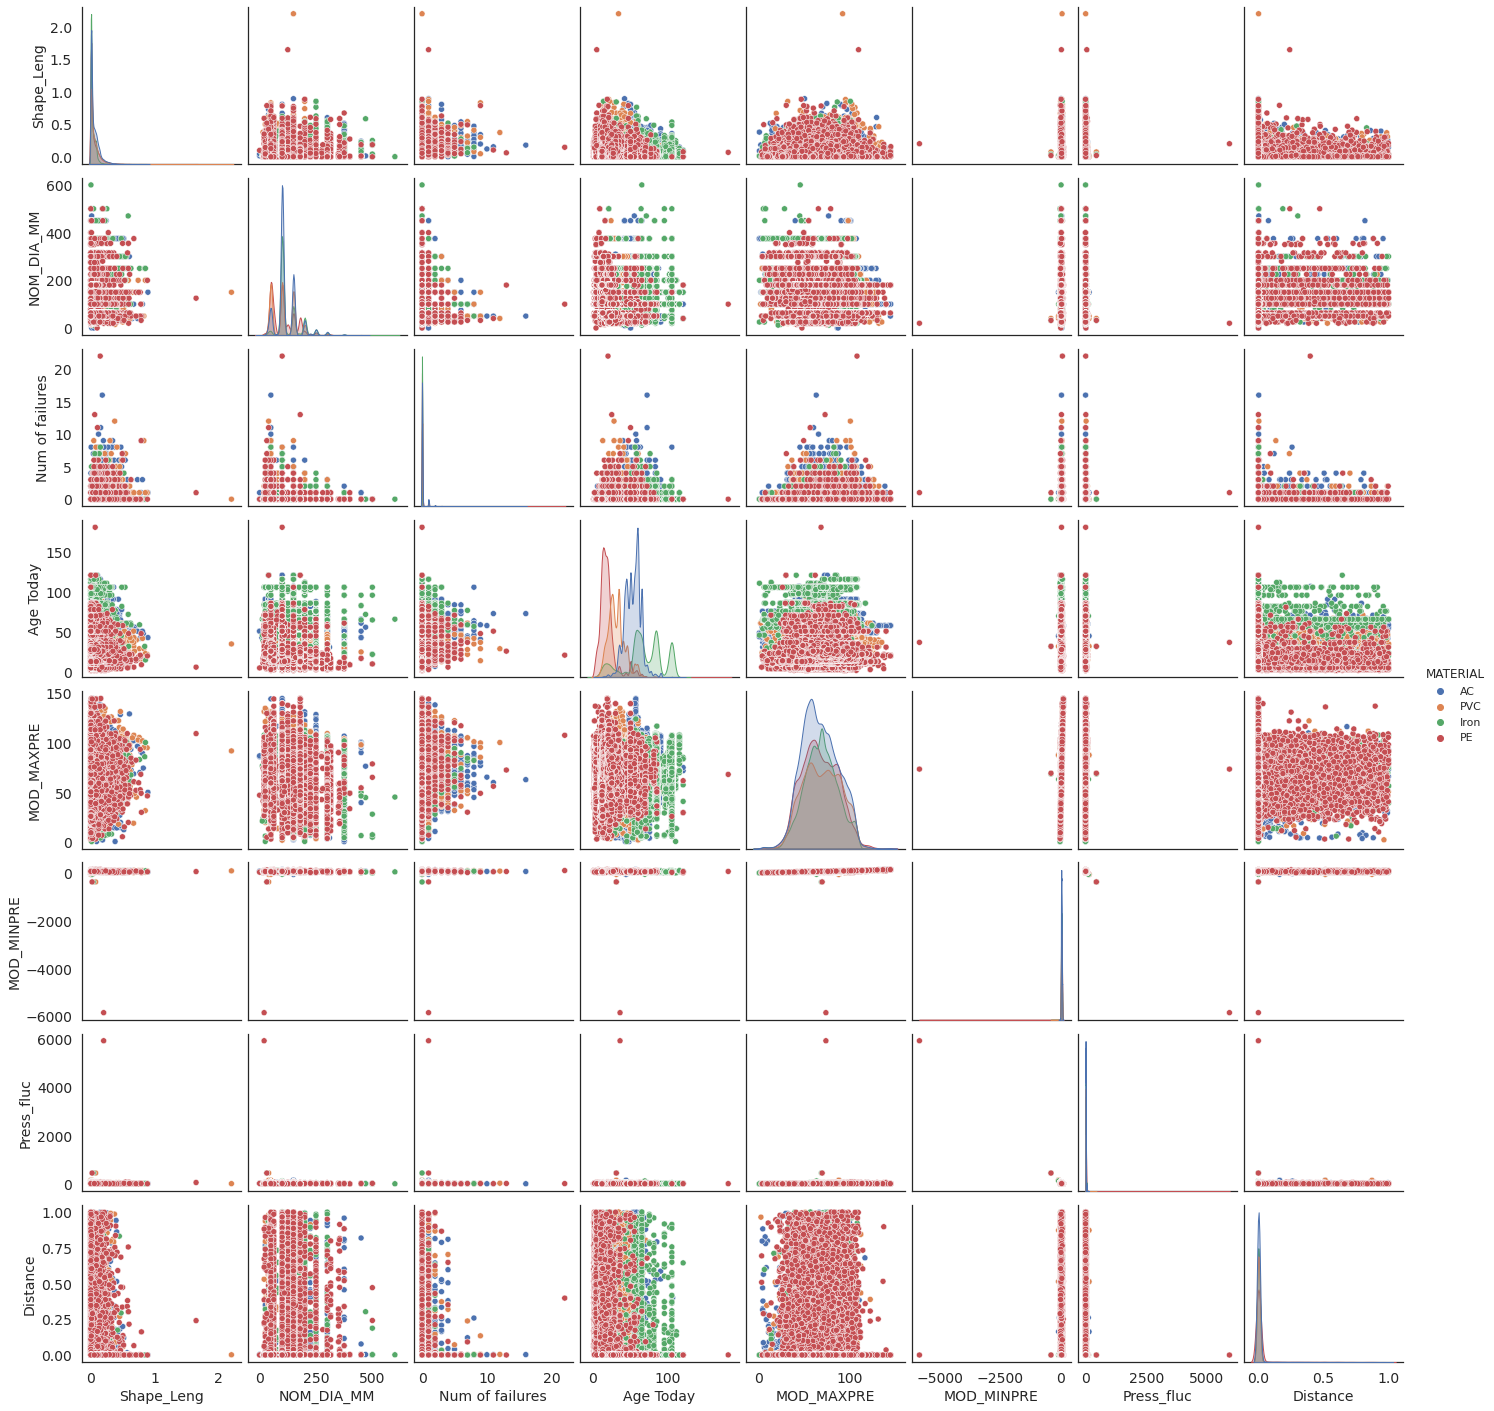

In [65]:
PiPress
sns.pairplot(PiPress, hue="MATERIAL")


# Not used ----------------------

In [ ]:
def getDistributionDistances(df):
    
    display(df['Distance'].describe())

    g=sns.boxplot(x=df['Distance'])
    g.set(xlim=(-2, 2))
    
getDistributionDistances(PiPress)

Pipe length with valid  NOM_DIA_MM and  MOD_MAXPRE 6751.53  from original  6864.60


/home/ubuntu/.local/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:165: RuntimeWarning: invalid value encountered in true_divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/home/ubuntu/.local/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


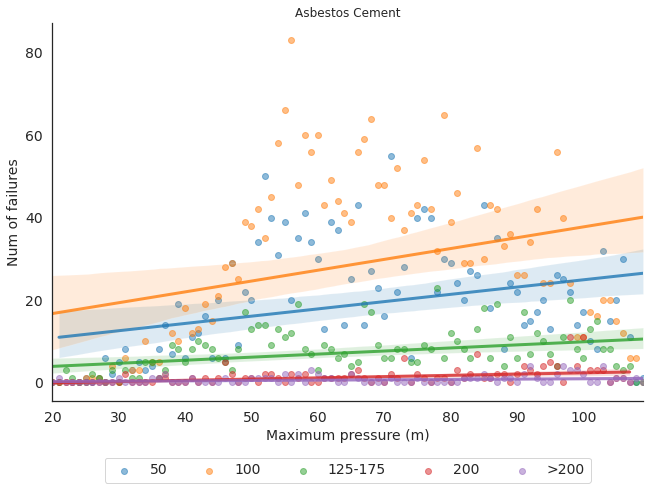

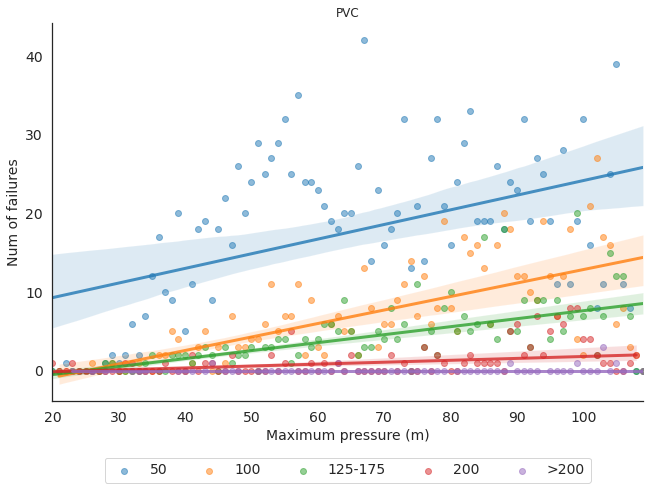

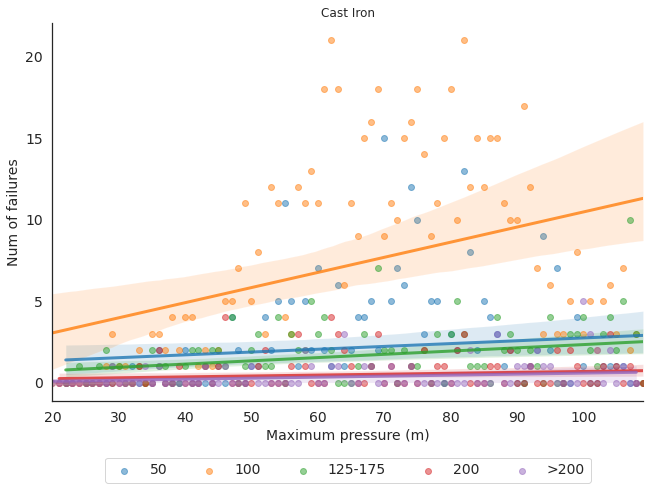

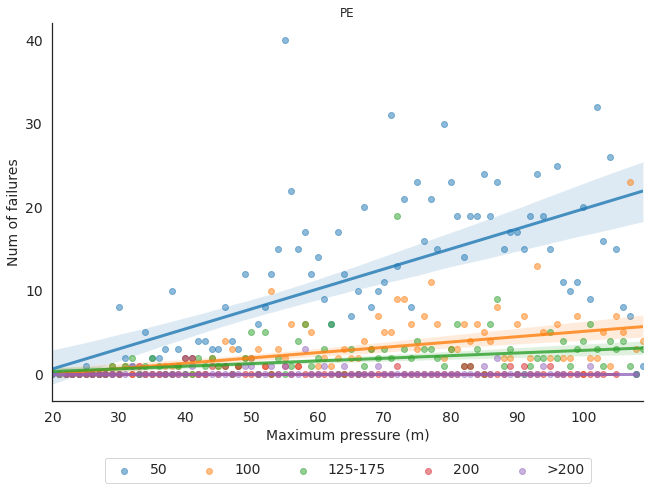

In [322]:
def getBurstRateVsPressByMatDiamScatter(df):
    
    Diam_bins2 = [25, 75, 115, 190, 225,800]
    DRange_labels2 = ['50','100', '125-175','200','>200']
    P_range = np.arange(20, 111, 1).tolist()
    P_labels = [str(i) for i in np.arange(20, 110, 1).tolist()]

    names = getMaterialConst()['NAME']
 
    dfGroupDiam= groupByTwoFactors(df,"Diameter (mm)","NOM_DIA_MM",Diam_bins2,DRange_labels2,
                                      "Maximum pressure (m)","MOD_MAXPRE",P_range,P_labels)
   
    dfGroupDiam= dfGroupDiam.reset_index().copy()
    dfGroupDiam["Maximum pressure (m)"]= dfGroupDiam["Maximum pressure (m)"].astype("int64")
    
    for m in MATERIALS_PREDOMI:
    
        mAux= dfGroupDiam[dfGroupDiam["MATERIAL"]==m].copy()
    
        g = sns.lmplot(data=mAux,x="Maximum pressure (m)", y="Num of failures", hue="Diameter (mm)",
                       height=6, aspect=1.5, palette='tab10',legend=False,robust=True, 
                       scatter_kws={'alpha': 0.5}, line_kws={'lw': 3,'alpha': 0.8})
        
        #g.set(ylim=(0, 1))
        g.axes[0,0].legend().remove()
        g.axes[0,0].legend(ncol=5, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))
        g.axes[0,0].set_title(names[m])
        
        g.savefig('Maps_Graph/PressureAnalysis/'+m+'PressureScatter' +'.png', dpi=200, bbox_inches='tight')  
    
    
    return g
    
    
getBurstRateVsPressByMatDiamScatter(PiPressAll.copy())